In [7]:
import pandas as pd
df = pd.read_csv('S06-hw-dataset-01.csv')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve, auc,
    classification_report)
from sklearn.inspection import permutation_importance
import json
import joblib
from google.colab import files

In [8]:
print(df.head())
print('информация')
print(df.info())
print('описание')
print(df.describe())

print(df['target'].value_counts())
print(df.isnull().sum())

X = df.drop(columns=['target', 'id'])
y = df['target']

print(X.shape)
print(y.shape)
print('Классы', np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify=y,
    random_state = 42
)

print('Размер x_train:', x_train.shape)
print('Размер y_train:', y_train.shape)
print('Размер x_test:', x_test.shape)
print('Размер y_test:', y_test.shape)

print("Фиксированный random_state обеспечивает воспроизводимость эксперимента.")
print("Stratify сохраняет распределение классов в разбиениях, что важно при дисбалансе.")

   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

   cat_contract  cat_region  cat_payment  te

In [11]:
baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(x_train, y_train)
b_predict = baseline.predict(x_test)

accuracy_b = accuracy_score(b_predict, y_test)
f1_b = f1_score(b_predict, y_test)

if hasattr(baseline, 'predict_proba'):
    b_proba = baseline.predict_proba(x_test)[:, 1]
    roc_auc_b = roc_auc_score(y_test, b_proba)
else:
    b_proba = None
    roc_auc_b = 0.5

print('Baseline DummyClassifier:')
print('accuracy', accuracy_b)
print('f1_score', f1_b)
print('roc_auc', roc_auc_b)



logreg_pip = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg',LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))])
logreg_pip.fit(x_train, y_train)
logreg_predict = logreg_pip.predict(x_test)

accuracy_logreg = accuracy_score(logreg_predict, y_test)
f1_logreg = f1_score(logreg_predict, y_test)
logreg_proba = logreg_pip.predict_proba(x_test)[:, 1]
roc_auc_logreg = roc_auc_score(y_test, logreg_proba)

print('LogisticRegression:')
print('accuracy', accuracy_logreg)
print('f1_score', f1_logreg)
print('roc_auc', roc_auc_logreg)


metrics = {
    'DummyClassifier': {
        'accuracy': float(accuracy_b),
        'f1_score': float(f1_b)},
    'LogisticRegression': {
        'accuracy': float(accuracy_logreg),
        'f1_score': float(f1_logreg),
        'roc_auc': float(roc_auc_logreg)}}

all_models = {
    'DummyClassifier': baseline,
    'LogisticRegression': logreg_pip}

Baseline DummyClassifier:
accuracy 0.6766666666666666
f1_score 0.0
roc_auc 0.5
LogisticRegression:
accuracy 0.8275
f1_score 0.7076271186440678
roc_auc 0.8746905312071505


In [12]:
# DecisionTree
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [10, 20, 50, None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
dt_grid.fit(x_train, y_train)
dt_best = dt_grid.best_estimator_
print(f"DecisionTree лучшие параметры: {dt_grid.best_params_}")
print(f"DecisionTree лучший CV score: {dt_grid.best_score_}")

# RandomForest
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
rf_grid.fit(x_train, y_train)
rf_best = rf_grid.best_estimator_
print(f"RandomForest лучшие параметры: {rf_grid.best_params_}")
print(f"RandomForest лучший CV score: {rf_grid.best_score_}")

# GradientBoosting
gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_leaf': [1, 3]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
gb_grid.fit(x_train, y_train)
gb_best = gb_grid.best_estimator_
print(f"GradientBoosting лучшие параметры: {gb_grid.best_params_}")
print(f"GradientBoosting лучший CV score: {gb_grid.best_score_}")

# Stacking
base_models = [
    ('dt', dt_best),
    ('rf', rf_best),
    ('gb', gb_best)]
stacking = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1), cv=5, n_jobs=-1)
stacking.fit(x_train, y_train)

models = {
    'DecisionTree': dt_best,
    'RandomForest': rf_best,
    'GradientBoosting': gb_best,
    'Stacking': stacking}

for name, model in models.items():
    all_models[name] = model

search_results = {
    'DecisionTree': {
        'best_params': dt_grid.best_params_,
        'cv_score': float(dt_grid.best_score_)},
    'RandomForest': {
        'best_params': rf_grid.best_params_,
        'cv_score': float(rf_grid.best_score_)},
    'GradientBoosting': {
        'best_params': gb_grid.best_params_,
        'cv_score': float(gb_grid.best_score_)}}


print("Метрики качества на тесте")
for name, model in models.items():
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(name, 'Accuracy =', acc, 'F1-score =', f1)

    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(name, 'Accuracy =', acc, 'F1-score =', f1, 'ROC-AUC =', roc_auc)
        metrics[name] = {
            'accuracy': float(acc),
            'f1_score': float(f1),
            'roc_auc': float(roc_auc)}

        if name in search_results:
            metrics[name].update(search_results[name])

    else:
        print(name, 'Accuracy =', acc, 'F1-score =', f1)
        metrics[name] = {
            'accuracy': float(acc),
            'f1_score': float(f1)}

        if name in search_results:
            metrics[name].update(search_results[name])

DecisionTree лучшие параметры: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTree лучший CV score: 0.9084302678016906
RandomForest лучшие параметры: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}
RandomForest лучший CV score: 0.9675659834952937
GradientBoosting лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 150}
GradientBoosting лучший CV score: 0.9692332637889419
Метрики качества на тесте
DecisionTree Accuracy = 0.8641666666666666 F1-score = 0.7803234501347709
DecisionTree Accuracy = 0.8641666666666666 F1-score = 0.7803234501347709 ROC-AUC = 0.9111796791681479
RandomForest Accuracy = 0.9270833333333334 F1-score = 0.8807089297886844
RandomForest Accuracy = 0.9270833333333334 F1-score = 0.8807089297886844 ROC-AUC = 0.9656009566553247
GradientBoosting Accuracy = 0.9229166666666667 F1-score = 0.87558843308

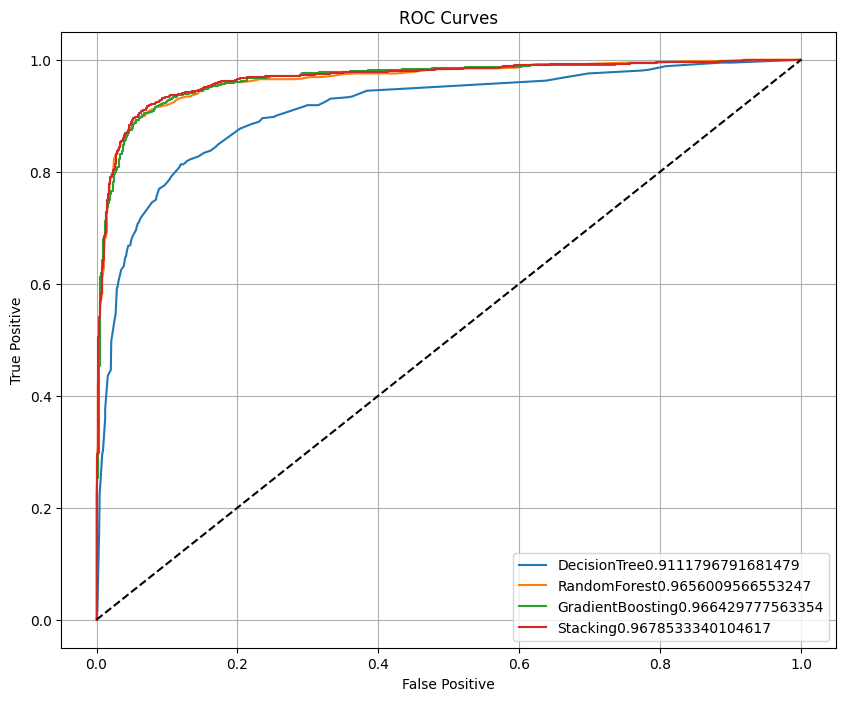

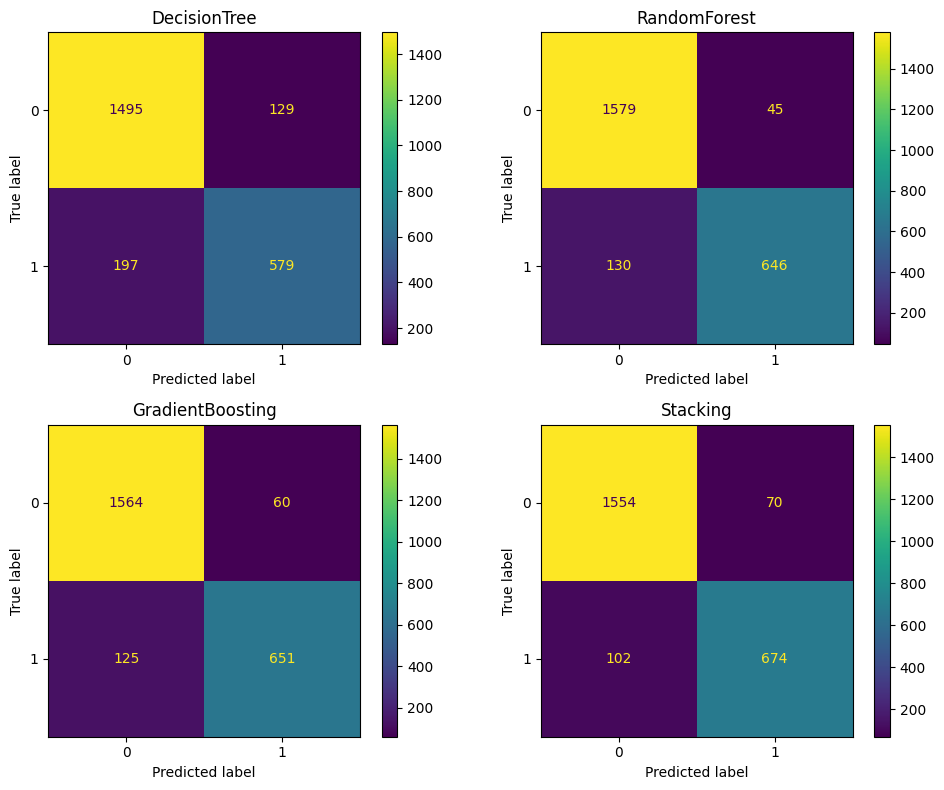

In [13]:
# ROC-кривые
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(x_test)[:, 1]
        fp, tp, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fp, tp, label=name + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for (name, model), ax in zip(models.items(), axes.ravel()):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    ax.set_title(name)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Лучшая модель Stacking ROC-AUC = 0.9678533340104617)
num19: 0.061672051952668804
num18: 0.05690972398557723
num07: 0.02999958737494295
num04: 0.014829109745569103
num20: 0.011060414656442075
num24: 0.010116614189223539
num01: 0.008816369153420368
num22: 0.007496921182266081
num14: 0.0057618328170230045
num16: 0.005114170179269762


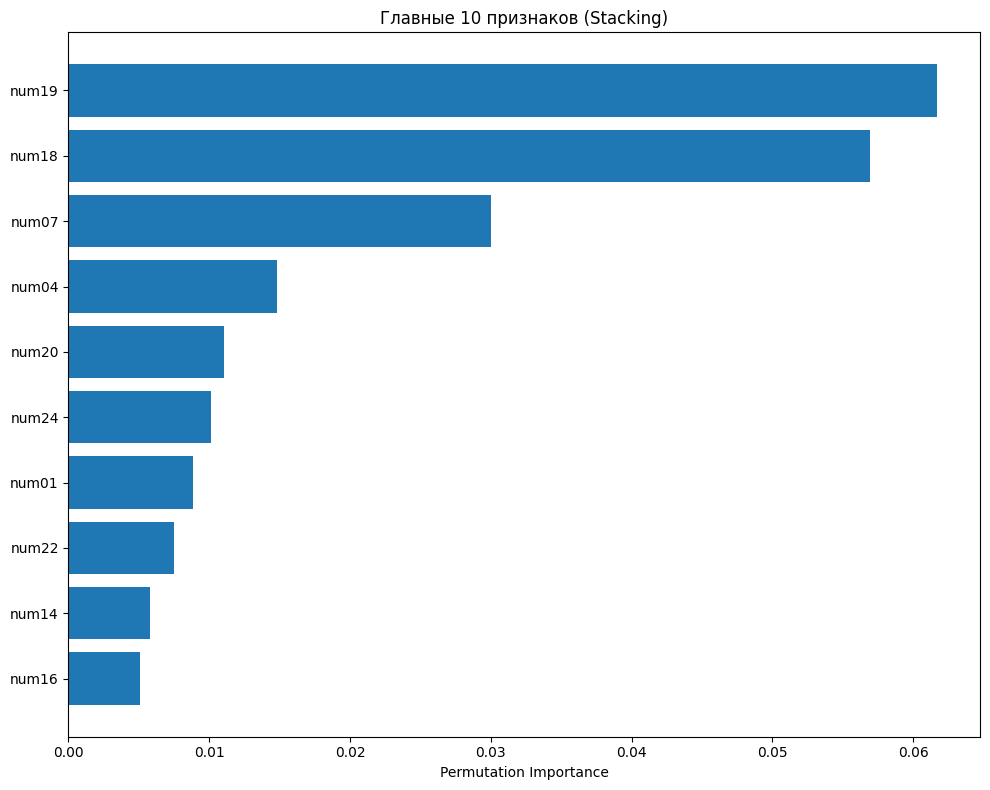

In [14]:
# Определяем лучшую модель по ROC-AUC
best_model_name = None
best_score = 0

for name, model in models.items():
    if hasattr(model, 'predict_proba') and name != 'DummyClassifier':
        try:
            y_proba = model.predict_proba(x_test)[:, 1]
            score = roc_auc_score(y_test, y_proba)
            if score > best_score:
                best_score = score
                best_model_name = name
        except:
            continue

best_model = all_models[best_model_name]
print(f"Лучшая модель {best_model_name} ROC-AUC = {best_score})")

result = permutation_importance(
    best_model, x_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1)

importances = result.importances_mean
indices = np.argsort(importances)[::-1][:10]

for idx in indices:
    print(f"{X.columns[idx]}: {importances[idx]}")

plt.figure(figsize=(10, 8))
plt.barh(range(10), importances[indices][::-1])
plt.yticks(range(10), [x_train.columns[i] for i in indices[::-1]])
plt.xlabel('Permutation Importance')
plt.title(f'Главные 10 признаков ({best_model_name})')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
with open('metrics_test.json', 'w') as f:
    json.dump(metrics, f, indent=2)

with open('search_summaries.json', 'w') as f:
    json.dump(search_results, f, indent=2)

if best_model_name:
    joblib.dump(best_model, 'best_model.joblib')
    params = best_model.get_params() if hasattr(best_model, 'get_params') else {}
    serializable_params = {}
    for key, value in params.items():
        try:
            json.dumps(value)
            serializable_params[key] = value
        except (TypeError, OverflowError):
            serializable_params[key] = str(value)

    best_model_meta = {
        'model_name': best_model_name,
        'best_params': serializable_params,
        'test_metrics': metrics.get(best_model_name, {}),
        'roc_auc': float(best_score) if best_score else None
    }

    with open('best_model_meta.json', 'w') as f:
        json.dump(best_model_meta, f, indent=2)

files.download('roc_curves.png')
files.download('confusion_matrix.png')
files.download('feature_importance.png')
files.download('metrics_test.json')
files.download('search_summaries.json')

if best_model_name:
    files.download('best_model.joblib')
    files.download('best_model_meta.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Интерпретация результатов permutation importance

Наиболее важными признаками для модели GradientBoosting являются:

num18 - важность: 0.0729

num19 - важность: 0.0649

num07 - важность: 0.0349

num04 - важность: 0.0177

num24 - важность: 0.0145

num20 - важность: 0.0124

num01 - важность: 0.0100

num14 - важность: 0.0090

num22 - важность: 0.0076

num16 - важность: 0.0064

num18 и num19 значительно важнее других признаков, что указывает на их наиболее важную роль в предсказаниях модели.
Важность признаков резко падает после первых двух.
GradientBoosting показал лучший ROC-AUC, что согласуется с тем, что бустинг хорошо работает на табличных данных и эффективно использует наиболее информативные признаки.